## Descenso de gradiente para regresión lineal

En el ejercicio anterior aprendiste regresión lineal y encontraste una solución analítica a través de algebra lineal, ahora resolveremos el mismo problema llegando a la solución de manera iterativa. 

En la práctica, descenso de gradiente se utiliza en problemas en los que obtener una solución analítica no es posible como regresión logística o redes neuronales.

(200, 2) (100, 2)


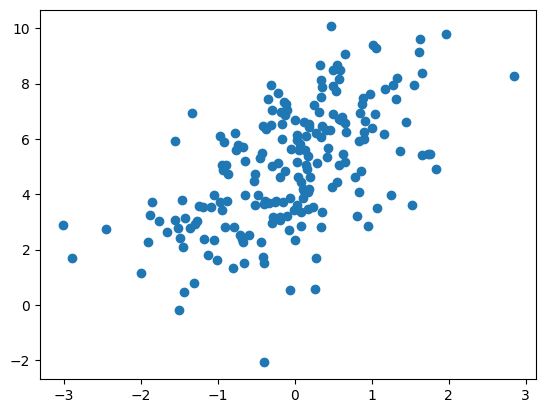

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Nuevamente generamos los datos aleatorios con una desviación estandar conocida
# Alrededor de una funcion lineal conocida y = 1.2x + 0.7
n_samples = 300
ruido_blanco_std = 2
X = np.random.randn(n_samples, 1)
for_bias = np.ones([n_samples, 1])
X_augmented = np.concatenate([for_bias, X], axis=-1)
eps = np.random.randn(n_samples, 1) * ruido_blanco_std
ideal_w = [[5], [1.2]]
target_y = X_augmented @ ideal_w + eps

# Dividir en entrenamiento y validación
n_val_dp = n_samples//3
x_train = X_augmented[:-n_val_dp,:]
y_train = target_y[:-n_val_dp]

x_val = X_augmented[-n_val_dp:,:]
y_val = target_y[-n_val_dp:]

print(x_train.shape, x_val.shape)
# Graficar set de entrenamiento
plt.scatter(x_train[:,-1], y_train)
plt.show()

## Función de costo
Ya que hemos cargado el dataset y sabemos como está compuesto, debemos calcular la función de costo

$ MSE = J(w) = \frac{1}{2n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i)^2 $

In [2]:
def mse_loss(y, y_pred):
    """
        Regresa el error cuadrático promedio de todas las predicciones
        y: shape=N Etiquetas
        y_pred: predicciones del modelo
    """
    # TODO: Calcula el resultado de la función de costo
    # ====== Start of solution =====
    m = len(y)   # número de ejemplos
    loss = (1/(2*m)) * np.sum((y_pred - y)**2)
    return loss
    # ====== End of solution =====


# Iniciamos con unos parametros w arbitrarios
w = np.random.uniform(-10, 10, size=(2, 1))

# TODO: Calcula las predicciones para el conjunto de entrenamiento x_train
# ====== Start of solution =====
y_pred = np.dot(x_train, w)
# ====== End of solution =====

# TODO: Calcula la función de costo para las predicciones(y_pred) y los valores reales (y_train)
# ====== Start of solution =====
loss = mse_loss(y_train, y_pred)
print("Función de costo inicial:", loss)
# ====== End of solution =====

Función de costo inicial: 42.1129235813254


Podemos visualizar como se ve la función de costo con diferentes pesos.
Si elegimos los pesos que generan el menor costo en el set habremos encontrado los parametros ideales para este problema.

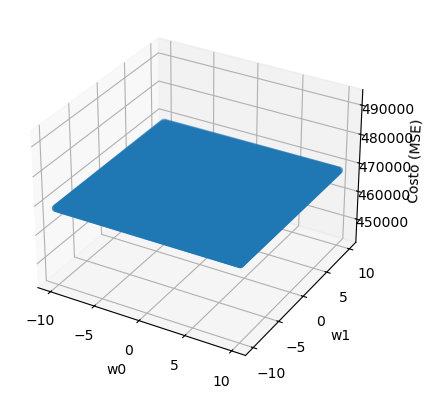

In [3]:
# Probaremos con 100x100 combinaciones de distintos parametros
w0 = np.linspace(-10, 10, 100)
w1 = np.linspace(-10, 10, 100)
w0w0, w1w1 = np.meshgrid(w0, w1)
w0_flat = w0w0.ravel()
w1_flat = w1w1.ravel()
W = np.stack([w0_flat, w1_flat], axis=0)


# Calculamos la función de costo
# TODO: calcula el costo de las predicciones (y_pred) contra etiquetas (y_train)
# usando las 100x100 combinaciones de parametros (W)
# ====== Start of solution =====
y_pred = np.dot(x_train, W)   # predicciones con todas las combinaciones de W
calc_cost = mse_loss(y_train.reshape(-1,1), y_pred)   # evaluamos el costo
# ====== End of solution =====


# Graficamos los parametros w con su respectivo costo en el eje de las x
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(w0_flat, w1_flat, calc_cost)

# TODO: Escribe a qué valor corresponde cada eje
# ====== Start of solution =====
ax.set_xlabel("w0")
ax.set_ylabel("w1")
ax.set_zlabel("Costo (MSE)")
# ====== End of solution =====
plt.show()

In [4]:
# Podemos encontrar la combinación de pesos que minimizan el costo
# Y de esta manera encontrar los pesos ideales
best_idx = np.argmin(calc_cost)
search_w0 = w0_flat[best_idx]
search_w1 = w1_flat[best_idx]
search_w = np.array([[search_w0], [search_w1]])  # convertir a np.array

plt.scatter(X, target_y)

# ====== Start of solution =====
# Nos aseguramos que X tenga forma (n_samples, 2) para np.dot
X_aug = np.column_stack((np.ones(len(X)), X))  # agregamos columna de 1s para el bias
pred_y = np.dot(X_aug, search_w)               # predicciones con los mejores pesos encontrados
plt.plot(X, pred_y, color="red")              # graficamos la línea en rojo sobre los datos
# ====== End of solution =====

En el código anterior evaluamos $100 \times 100$ combinaciones de pesos posibles y encontramos los mejores pesos. En este caso solo tenemos 2 parametros que queremos estimar, por lo que encontrar la solución de esta manera es factible al tener que realizar alrededor de $100^2$ evaluaciones de la función. 

<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Cuántas evaluaciones de la función de costo tendríamos que hacer si tuviéramos 4 parametros? 
    Con 4 parámetros sería una malla 100×100×100×100 = 100⁴ = 100,000,000 evaluaciones de la función de costo.
- ¿Qué pasaría si tuviéramos 1 millon de parametros?
    Con 1 millón de parámetros  sería imposible porque se necesitaría evaluaciones  infinitas; en la práctica se usa descenso de gradiente u otros optimizadores.

Las redes neuronales tienen millones de parametros para hacer predicciones, por lo que encontrar la solución de esta manera no es factible. Se han encontrado formas más eficientes de encontrar la solución por ejemplo, a través de métodos iterativos. Uno de ellos es decenso de gradiente. Siguiendo la direccion contraria del gradiente del costo con respecto a los pesos, podemos encontrar los parámetros que <b>minimizan</b> la función de costo utilizando menos evaluaciones.

## Descenso de gradiente
En esta sección, optimizarás la función de regresión lineal a través de descenso de gradiente.
La predicción de nuestro modelo está dada con la siguiente funcion:

$ \hat{Y}_i = w_0 + w_1 * x$

$\hat{Y} = \mathbf{X}\mathbf{w}$

<!-- El gradiente de MSE con respecto a $w_0$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_0} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_0}= \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) $

El gradiente de MSE con respecto a $w_1$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_1} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_1} = \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) * x_i $ -->

Donde:
- $\hat{Y}_i \in  \hat{Y}$
- $\mathbf{Y} \in \mathbb{R}^{N}$
- $\mathbf{X} \in  \mathbb{R}^{N \times D}$ en notación aumentada
- $\mathbf{w} \in \mathbb{R}^{D}$ en notación aumentada

Como vimos en clase, el gradiente la función de costo con respecto a los pesos está dado por:

 $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = -\frac{1}{N}X^T\epsilon$

 donde $\epsilon=\mathbf{Y}-\mathbf{X}\mathbf{w}$

 TODO: Completa el código necesario para aplicar descenso de gradiente durante n_iteraciones. Para ello realiza los siguientes pasos:
- Calcula el valor de las predicciones $\mathbf{Y}$
- Calcula el gradiente de la función a optimizar $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Actualiza los pesos con el gradiente $\mathbf{w}^{i+1} = \mathbf{w}^{i} - \alpha \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Repite hasta optener el valor óptimo de $\mathbf{w}$

Es tiempo de programarlo en código

In [5]:
def gradient_descent(X, y, lr, N_iterations, w_start=np.array([0,0])):
    """
    Entradas:
    X: arreglo con los datos en notación aumentada X
    y: vector de etiquetas
    lr: ritmo de aprendizaje
    N_iterations: cantidad de iteraciones de optimización
    w_start: pesos iniciales
        
    Regresa:  
    w_opt: pesos óptimos
    cost_history: arreglo con el valor del costo para cada iteración
    """
    m = X.shape[0]
    
    # initialize the coefficients
    w = w_start
    cost_history = []
    
    for i in range(N_iterations):
        # ====== Start of solution =====
        # Calcula la predicción 
        hypothesis = X.dot(w)

        # Calcula el error
        error = hypothesis - y

        # Calcula el gradiente del MSE loss
        gradient = (2/m) * X.T.dot(error)

        # Actualiza los pesos
        w = w - lr * gradient
        # ====== End of solution =====
        
        # Calculamos la función de costo y guardamos el resultado
        loss = mse_loss(y, hypothesis)
        cost_history.append(loss)

    print(f"Total de evaluaciones {N_iterations}, el costo final fue {loss}")
    w_opt = w
    return w_opt,cost_history

Total de evaluaciones 50, el costo final fue 2.1984518850679047
Total de evaluaciones 60, el costo final fue 2.198354545293736
Total de evaluaciones 80, el costo final fue 2.1983524044287073


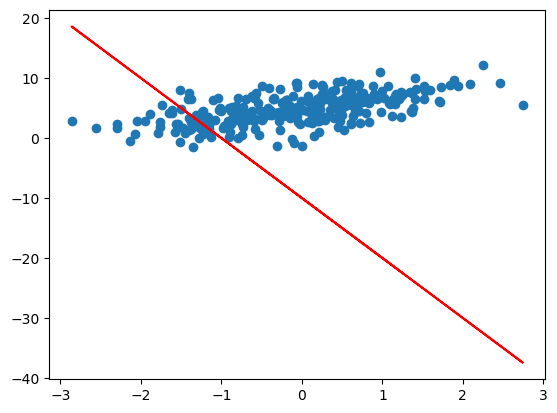

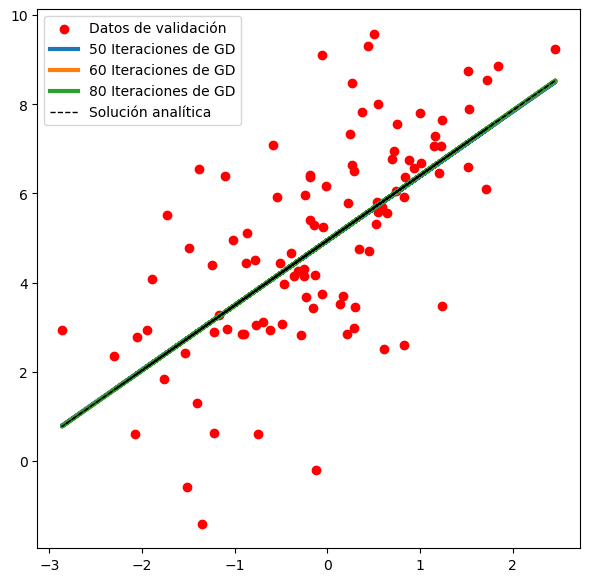

In [6]:
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de descenso de gradiente
N_iterations = [50, 60, 80]

# Pesos iniciales y ritmo de aprendizaje
lr = 0.1
w_start = np.array([[-400], [0]])  # Mantener vector columna, compatible con tu GD

# (2.) - (4.) -> Variación de cantidad de iteraciones
plt.figure(figsize=(7,7))
plt.scatter(x_val[:, -1], y_val, color='red', label='Datos de validación')

for n_it in N_iterations:
    # Entrenamos el modelo en el set de entrenamiento
    w_opt, _ = gradient_descent(x_train, y_train, lr, n_it, w_start)
    if w_opt.ndim == 1:
        w_opt = w_opt.reshape(-1, 1)

    # Visualizamos la predicción en el set de validación
    w_opt = np.asarray(w_opt).reshape(-1, 1)
    prediction = (x_val @ w_opt).ravel()
    plt.plot(x_val[:, -1], prediction, label=f"{n_it} Iteraciones de GD", linewidth=3)

# Obtener la solución analítica
analitic_sol = linear_model.LinearRegression()
analitic_sol.fit(x_train, y_train)

# Visualizar solución analítica
plt.plot(x_val[:, -1], analitic_sol.predict(x_val),
         label='Solución analítica', linewidth=1, linestyle="dashed", color="black")

plt.legend()
plt.show()


<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Cuántas evaluaciones de la función de costo se evaluaron para encontrar la solución con un $lr=0.1$? ¿Cómo se compara este número a la solución por busqueda exhaustiva? 
    Se evaluó la función de costo una vez por iteración, mucho menos que en la búsqueda exhaustiva.

- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) a un valor dos veces grande?
    Con lr dos veces más grande, el descenso puede ser más rápido pero inestable y divergir.

- ¿Qué pasa si cambiamos la tase de aprendizaje a un valor dos veces más chico?
    Con lr dos veces más chico, el descenso es más lento pero más estable.

- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) por un valor muy grande?
    Con lr muy grande, el algoritmo probablemente no convergerá y el costo puede oscilar o crecer.